### 1. 样本分析

#### 1.1 贷后表现期确定

根据贷后各变量对S1D30,S1D4-30,S3D15这三种风险识别的IV值来判定

In [1]:
# -*- coding: utf-8 -*-

%matplotlib inline
from pyhive import hive
import os
import time
import random
import math as ma
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from xgboost.sklearn import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (RandomTreesEmbedding, RandomForestClassifier,
                              GradientBoostingClassifier)
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from scipy.stats import ks_2samp
from sklearn.metrics import roc_auc_score,roc_curve,precision_recall_curve, auc 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import Imputer
from sklearn.ensemble import  VotingClassifier
from sklearn2pmml import PMMLPipeline

from sklearn.cluster import FeatureAgglomeration
from sklearn import preprocessing

from lightgbm.sklearn import LGBMClassifier


import pyWoE
#import LR

In [2]:
# load data

from pyhive import hive
import pandas as pd
# conn = hive.Connection(host='', port=10000, username='', password='', database='vdm_ds_dev', auth='LDAP')
# raw_data = pd.read_sql("select t.* from t", conn)

# #修改Column名称
# raw_data.columns = raw_data.columns.str[2:]
# raw_data['apply_date'] = raw_data.apply_time.str[:10]
# raw_data['apply_month'] = raw_data.apply_time.str[:7]

rawdata_path = '/home/jovyan/multi_loan/Multiloan/%s_%s_%s_data.csv' % ('2017-12-10', '2018-08-28', 'MultiloanV2')
if os.path.exists(rawdata_path):
    raw_data = pd.read_csv(rawdata_path, encoding='utf-8')
else:
    conn = hive.Connection(host='', port=10000, username='', password='', database='vdm_ds_dev', auth='LDAP')
    raw_data = pd.read_sql("select t.* from  t", conn)
    raw_data.columns = raw_data.columns.str[2:]
    raw_data['apply_date'] = raw_data.apply_time.str[:10]
    raw_data['apply_month'] = raw_data.apply_time.str[:7]
    raw_data.to_csv(rawdata_path,index=False, sep=',', encoding='utf-8', header=True)
    print('已经保存在：' + rawdata_path)


已经保存在：/home/jovyan/multi_loan/Multiloan/2017-12-10_2018-08-28_MultiloanV2_data.csv


In [3]:
# IV 值计算
target_label = 's3d15'
print('label为: %s' % target_label)
print('输出各变量的IV...')

VAR = []
IV = []
apply_month = []
    
woe = pyWoE.WoE(qnt_num=10, min_block_size=10, v_type='c', t_type='b')
except_cols = ['user_id', 'order_original_id', 'apply_time', 'overdue_1','overdue_2','overdue_3','is_loaned'
               ,'overdue_max','s1d30','s1d4_30','s3d15','apply_date','apply_month']
all_cols = raw_data.columns
continues_cols = [x for x in set(all_cols) if x not in set(except_cols)]
# continues_cols = ['app_platform_num_after_3m','app_platform_num_after_2m','app_platform_num_after_1m',
#                  'app_platform_num_after_25d','app_platform_num_after_21d','app_platform_num_after_15d',
#                  'app_platform_num_after_7d','app_platform_num_after_3d']


raw_data_ins = raw_data[raw_data['apply_date']<='2018-06-28']
apply_month = ['2017-12','2018-01','2018-02','2018-03','2018-04','2018-05','2018-06']

# for i in apply_month:
#     raw_data_group = raw_data_ins[raw_data_ins['apply_month']==i]
#     for var_name in continues_cols:
#         woe.fit(pd.Series(raw_data_group[var_name]), pd.Series(raw_data_group[target_label]))
#         VAR.append(var_name)
#         IV.append(woe.iv)
#     apply_month.append(i)

for var_name in continues_cols:
    woe.fit(pd.Series(raw_data_ins[var_name]), pd.Series(raw_data_ins[target_label]))
    VAR.append(var_name)
    IV.append(woe.iv)


iv_df = pd.DataFrame({"feature": VAR})
iv_df.loc[:, 'IV'] = IV
iv_df.loc[:, 'label'] = target_label
#iv_df.loc[:, 'apply_month'] = apply_month
iv_df = iv_df.sort_values(by=['IV'], ascending=False)
iv_df.loc[:, 'idx'] = range(len(iv_df))
print(iv_df.iloc[0:50,:])

#iv_df.to_csv(OutputPath+'MultiLoan_Feature_IV.csv')

label为: s3d15
输出各变量的IV...
                          feature        IV  label  idx
12    app_platform_num_after_2m3m  1.129992  s3d15    0
13    app_platform_num_after_1m3m  0.810294  s3d15    1
23   app_platform_num_after_25d3m  0.659735  s3d15    2
6    app_platform_num_after_21d3m  0.569931  s3d15    3
29    app_platform_num_after_1m2m  0.461089  s3d15    4
14      app_platform_num_after_1m  0.440130  s3d15    5
32   app_platform_num_after_25d2m  0.431432  s3d15    6
30   app_platform_num_after_15d3m  0.430675  s3d15    7
2      app_platform_num_after_25d  0.424119  s3d15    8
0      app_platform_num_after_21d  0.402978  s3d15    9
22   app_platform_num_after_21d2m  0.369219  s3d15   10
36   app_platform_num_after_25d1m  0.365442  s3d15   11
25  app_platform_num_after_21d25d  0.337409  s3d15   12
10     app_platform_num_after_15d  0.330993  s3d15   13
1    app_platform_num_after_21d1m  0.300683  s3d15   14
26   app_platform_num_after_15d2m  0.276797  s3d15   15
21  app_platform_num_a

In [34]:
# IV 值计算
target_label = 's3d15'
print('label为: %s' % target_label)
print('输出各变量的IV...')

VAR = []
IV = []
month = []
    
woe = pyWoE.WoE(qnt_num=10, min_block_size=10, v_type='c', t_type='b')
except_cols = ['user_id', 'order_original_id', 'apply_time', 'overdue_1','overdue_2','overdue_3','is_loaned'
               ,'overdue_max','s1d30','s1d4_30','s3d15','apply_date','apply_month']
all_cols = raw_data.columns
continues_cols = [x for x in set(all_cols) if x not in set(except_cols)]
# continues_cols = ['app_platform_num_after_3m','app_platform_num_after_2m','app_platform_num_after_1m',
#                  'app_platform_num_after_25d','app_platform_num_after_21d','app_platform_num_after_15d',
#                  'app_platform_num_after_7d','app_platform_num_after_3d']


raw_data_ins = raw_data[raw_data['apply_date']<='2018-06-28']
months = ['2017-12','2018-01','2018-02','2018-03','2018-04','2018-05']

for i in months:
    raw_data_group = raw_data_ins[raw_data_ins['apply_month']==i]
    for var_name in continues_cols:
        woe.fit(pd.Series(raw_data_group[var_name]), pd.Series(raw_data_group[target_label]))
        VAR.append(var_name)
        IV.append(woe.iv)
        month.append(i)

iv_df = pd.DataFrame({"feature": VAR})
iv_df.loc[:, 'IV'] = IV
iv_df.loc[:, 'label'] = target_label
iv_df.loc[:, 'apply_month'] = month
iv_df = iv_df.sort_values(by=['IV'], ascending=False)
iv_df.loc[:, 'idx'] = range(len(iv_df))
print(iv_df)

label为: s3d15
输出各变量的IV...
                       feature        IV  label apply_month  idx
34   app_platform_num_after_1m  0.562652  s3d15     2018-04    0
26   app_platform_num_after_1m  0.546630  s3d15     2018-03    1
35  app_platform_num_after_25d  0.533874  s3d15     2018-04    2
36  app_platform_num_after_21d  0.503969  s3d15     2018-04    3
27  app_platform_num_after_25d  0.502790  s3d15     2018-03    4
28  app_platform_num_after_21d  0.467959  s3d15     2018-03    5
2    app_platform_num_after_1m  0.463469  s3d15     2017-12    6
3   app_platform_num_after_25d  0.451223  s3d15     2017-12    7
4   app_platform_num_after_21d  0.445697  s3d15     2017-12    8
19  app_platform_num_after_25d  0.431395  s3d15     2018-02    9
42   app_platform_num_after_1m  0.425654  s3d15     2018-05   10
18   app_platform_num_after_1m  0.421312  s3d15     2018-02   11
25   app_platform_num_after_2m  0.379673  s3d15     2018-03   12
37  app_platform_num_after_15d  0.378795  s3d15     2018-04   13

#### 1.2 贷前贷后波动分析

① 先固定贷前一个月查询次数，分析贷后21d，25d，1m的波动覆盖的风险情况

In [39]:
## EDD Check
def EDD_Calculate(InputDf,GroupVar,GroupValue,Cols):
    Output=pd.DataFrame()
    for Group_i in set(GroupValue):
        OutputPre=pd.DataFrame()
        OutputPre=pd.DataFrame(InputDf[InputDf[GroupVar]==Group_i][Cols].describe().T,)
        OutputPre.loc[:,'TotalCount']=InputDf[InputDf[GroupVar]==Group_i][Cols].fillna(0).count()
        OutputPre.loc[:,GroupVar]=Group_i
        Output=pd.concat([Output,OutputPre],axis=0)
    return Output

In [40]:
GroupVar='apply_month'
GroupValue=['2017-12','2018-01','2018-02','2018-03','2018-04','2018-05','2018-06','2018-07']
Cols = continues_cols
EDD_df=EDD_Calculate(raw_data,GroupVar,GroupValue,Cols)
# EDD_df.to_csv(OutputPath+'MultiLoan_Feature_EDD.csv')

In [41]:
EDD_df.head()

,count,mean,std,min,25%,50%,75%,max,TotalCount,apply_month
app_platform_num_after_25d,99189.0,3.343365,4.321141,0.0,0.000000,2.0,5.0,74.0,99189,2018-05
app_platform_num_after_3m,99189.0,14.180322,13.529005,0.0,4.000000,10.0,19.0,174.0,99189,2018-05
app_platform_num_after_21d25d,64676.0,0.773009,0.331893,0.0,0.666667,1.0,1.0,1.0,99189,2018-05
app_platform_num_after_3d7d,24007.0,0.333070,0.377613,0.0,0.000000,0.2,0.5,1.0,99189,2018-05
app_platform_num_after_7d,99189.0,0.695047,1.589342,0.0,0.000000,0.0,0.0,44.0,99189,2018-05


In [5]:
import findspark
findspark.init("/opt/spark")
import os
from nxmodel import dstool, version
from nxmodel.mspark import operator as op
os.environ['PYSPARK_PYTHON'] = '/usr/local/python3/bin/python3'
os.environ['PYSPARK_DRIVER_PYTHON'] = '/opt/conda/bin/python3'
os.environ['HADOOP_HOME'] = '/opt/cloudera/parcels/CDH/lib/hadoop'
os.environ['HADOOP_COMMON_LIB_NATIVE_DIR'] = '/opt/cloudera/parcels/CDH/lib/hadoop/lib/native'
config = {
     "nxmodel.spark.config.spark.executorEnv.JAVA_HOME": "/usr/java/jdk1.8.0_74",
     "nxmodel.spark.config.spark.executor.extraJavaOptions": "-XX:+PrintGCDetails -XX:+PrintGCTimeStamps -XX:MetaspaceSize=256m",
     "nxmodel.spark.config.spark.executor.cores": "1",
     "nxmodel.spark.config.spark.yarn.queue": "root.ds_prod_etl.default"
     }
    
###如果需要按照时间切片，运行如下脚本demo
dstool.feature_stats('vdm_ds_dev.zxj_multiloan_version_2_apply_after_base_2', tag_table=None, time_groups='total'
                     , config=config,sink_table='vdm_ds_dev.zxj_order_feature_stats_3')

2018-08-31 14:54:10,929 - context - INFO - pyspark.python: /usr/local/python3/bin/python3
2018-08-31 14:54:10,933 - context - INFO - pyspark.driver.python: /opt/conda/bin/python3
2018-08-31 14:54:10,935 - conf_utils - INFO - find nxmodel wheel package: /etc/nxmodel/lib/nxmodel-0.11.1-py3-none-any.whl
2018-08-31 14:54:10,937 - context - INFO - config spark with spark.executorEnv.JAVA_HOME=/usr/java/jdk1.8.0_74
2018-08-31 14:54:10,938 - context - INFO - config spark with spark.executor.extraJavaOptions=-XX:+PrintGCDetails -XX:+PrintGCTimeStamps -XX:MetaspaceSize=256m
2018-08-31 14:54:10,939 - context - INFO - config spark with spark.executor.cores=1
2018-08-31 14:54:10,940 - context - INFO - config spark with spark.yarn.queue=root.ds_prod_etl.default
2018-08-31 14:54:48,434 - features - INFO - receive flow config: 
{'nxmodel.spark.config.spark.app.name': 'feature-stats.vdm_ds_dev.zxj_multiloan_version_2_apply_after_base_2',
 'nxmodel.spark.config.spark.executor.cores': '1',
 'nxmodel.spa

2018-08-31 14:55:09,539 - engine - INFO - processor stats-features finished.
2018-08-31 14:55:09,541 - engine - INFO - run processor filter-column(SparkSql) ... 
2018-08-31 14:55:09,541 - sparksql - INFO - exec spark sql: 
    select source_table, variable, plat, loan_type
        , time_type, time_session, dt, score_cnt, score_null_cnt, score_null_ratio
        , score_unique_cnt, score_stddev, score_avg, score_min, score_max
        , score_top_max, score_top_min, score_p5, score_p25, score_median
        , score_p75, score_p95
    from stats_result
    
2018-08-31 14:55:09,575 - engine - INFO - processor filter-column finished.
2018-08-31 14:55:09,576 - engine - INFO - run processor save-stats(SaveToHive) ... 
2018-08-31 14:55:09,774 - sparksql - INFO - save data to hive with sql : INSERT OVERWRITE TABLE vdm_ds_dev.zxj_order_feature_stats_3 PARTITION (source_table, dt) 
 SELECT variable, plat, loan_type, time_type, time_session, score_cnt, score_null_cnt, score_null_ratio, score_uni

app_platform_num_after_3m
缺失率为: 0.0000
输出变量的数据分布...


/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


初始化等频分箱...
[-inf, 2.0, 4.0, 6.0, 10.0, 15.0, 23.0]


/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


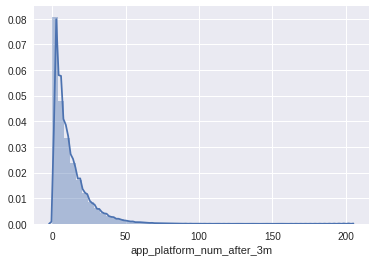

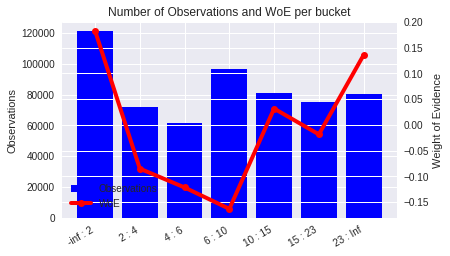

自动分箱调整...
[-inf, 2.0]


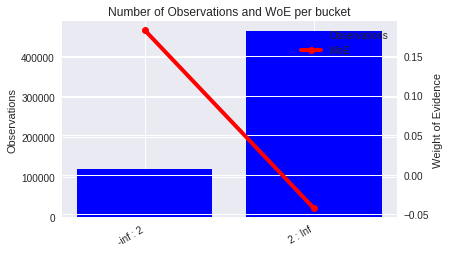

选择最终的woe分箱方法...
app_platform_num_after_2m
缺失率为: 0.0000
输出变量的数据分布...
初始化等频分箱...
[-inf, 2.0, 4.0, 7.0, 10.0, 16.0]


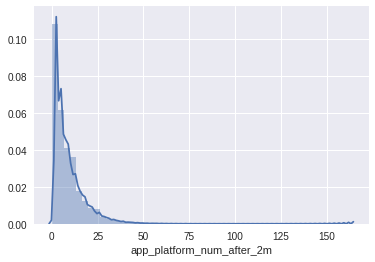

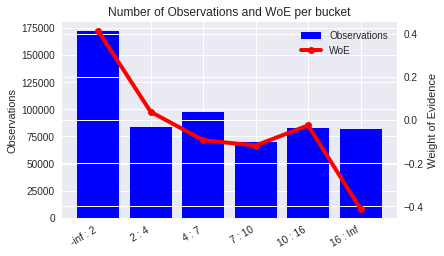

自动分箱调整...
[-inf, 2.0, 4.0, 16.0]


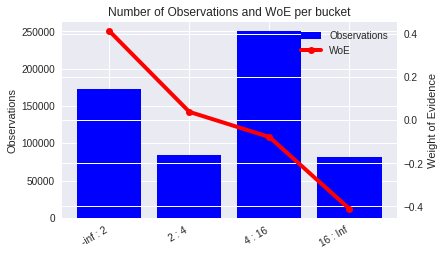

选择最终的woe分箱方法...
app_platform_num_after_1m
缺失率为: 0.0000
输出变量的数据分布...
初始化等频分箱...
[-inf, 2.0, 3.0, 5.0, 8.0]


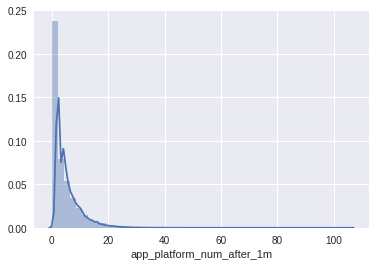

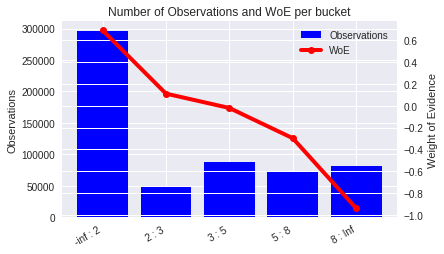

自动分箱调整...
[-inf, 2.0, 3.0, 5.0, 8.0]


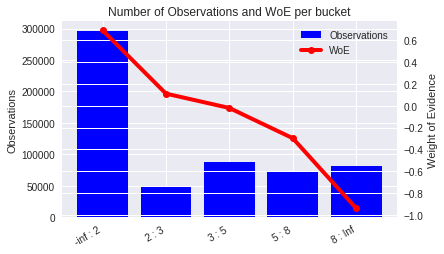

选择最终的woe分箱方法...
app_platform_num_after_25d
缺失率为: 0.0000
输出变量的数据分布...
初始化等频分箱...
[-inf, 2.0, 4.0, 7.0]


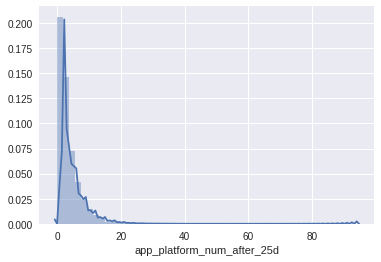

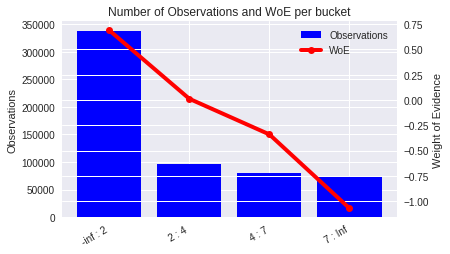

自动分箱调整...
[-inf, 2.0, 4.0, 7.0]


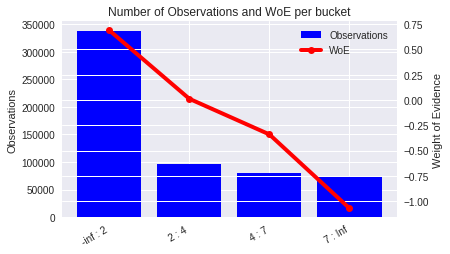

选择最终的woe分箱方法...
app_platform_num_after_21d
缺失率为: 0.0000
输出变量的数据分布...
初始化等频分箱...
[-inf, 1.0, 2.0, 3.0, 6.0]


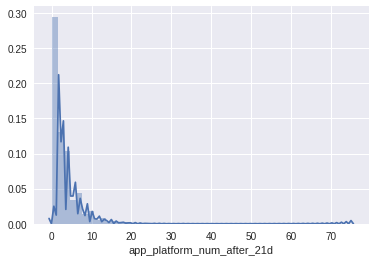

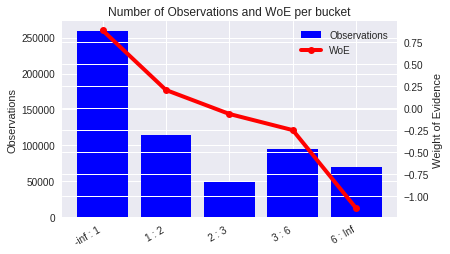

自动分箱调整...
[-inf, 1.0, 2.0, 3.0, 6.0]


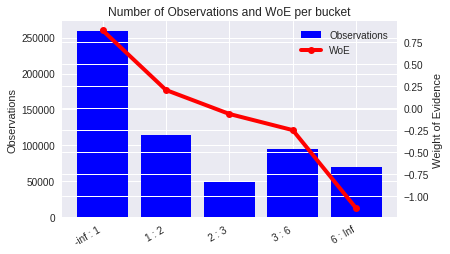

选择最终的woe分箱方法...
app_platform_num_after_15d
缺失率为: 0.0000
输出变量的数据分布...
初始化等频分箱...
[-inf, 2.0, 4.0]


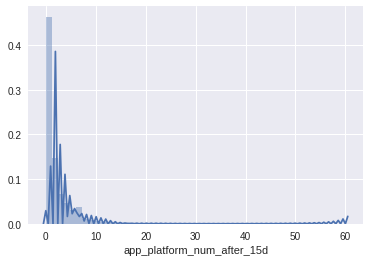

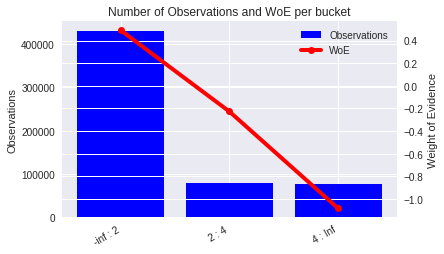

自动分箱调整...
[-inf, 2.0, 4.0]


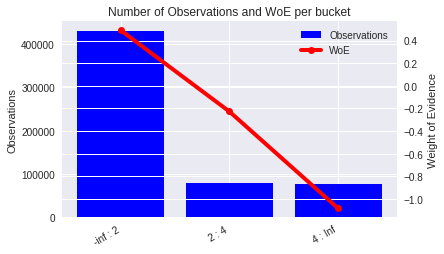

选择最终的woe分箱方法...
app_platform_num_3m
缺失率为: 0.0000
输出变量的数据分布...
初始化等频分箱...
[-inf, 4.0, 6.0, 8.0, 10.0, 12.0, 15.0]


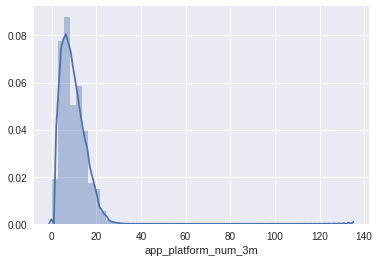

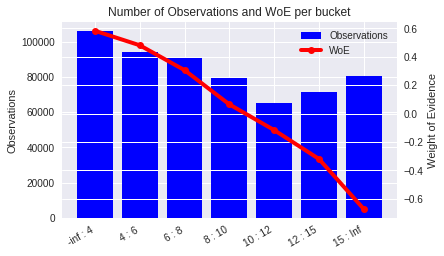

自动分箱调整...
[-inf, 4.0, 6.0, 8.0, 10.0, 12.0, 15.0]


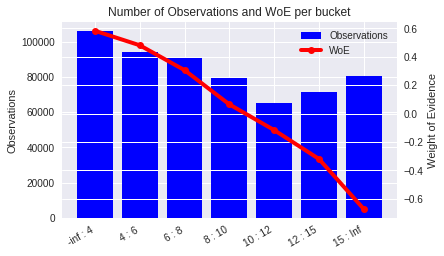

选择最终的woe分箱方法...
app_platform_num_1m
缺失率为: 0.0000
输出变量的数据分布...
初始化等频分箱...
[-inf, 2.0, 3.0, 4.0, 6.0, 8.0]


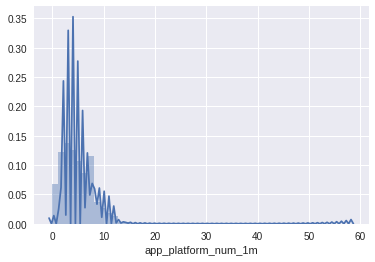

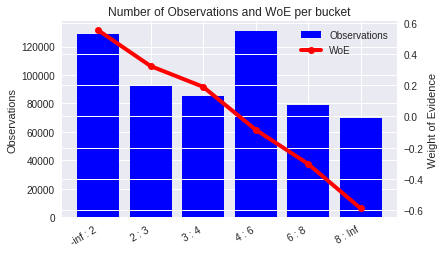

自动分箱调整...
[-inf, 2.0, 3.0, 4.0, 6.0, 8.0]


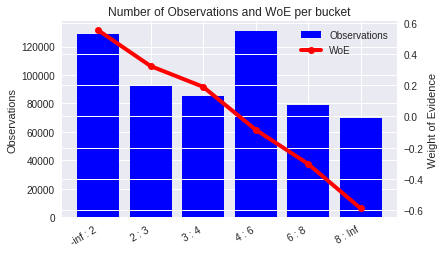

选择最终的woe分箱方法...
app_platform_num_after_21d1m
缺失率为: 0.0000
输出变量的数据分布...
初始化等频分箱...
[-inf, 0.2496878901373283, 0.5994005994005994, 0.9950248756218907, 0.9966777408637875]


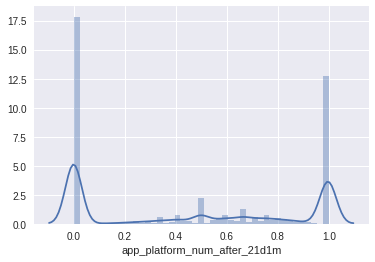

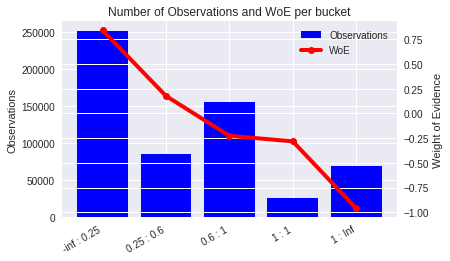

自动分箱调整...
[-inf, 0.2496878901373283, 0.5994005994005994, 0.9950248756218907, 0.9966777408637875]


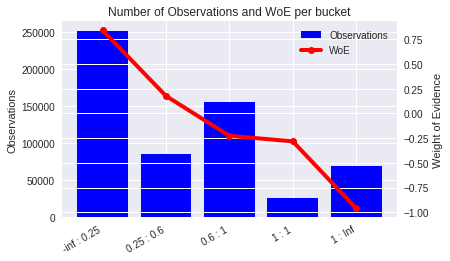

选择最终的woe分箱方法...
app_platform_num_after_25d1m
缺失率为: 0.0000
输出变量的数据分布...
初始化等频分箱...
[-inf, 0.5549389567147613, 0.8455034588777863, 0.9950248756218907, 0.9975062344139651]


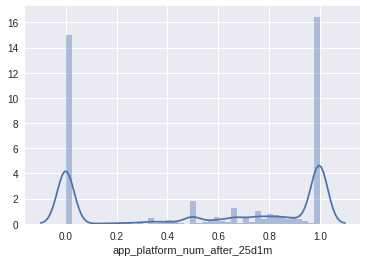

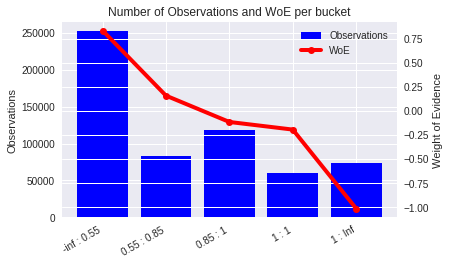

自动分箱调整...
[-inf, 0.5549389567147613, 0.8455034588777863, 0.9950248756218907, 0.9975062344139651]


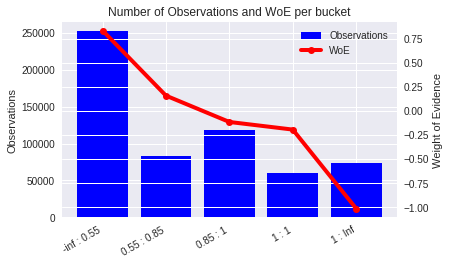

选择最终的woe分箱方法...
app_platform_num_after_1m3m
缺失率为: 0.0000
输出变量的数据分布...
初始化等频分箱...
[-inf, 0.2351557907113462, 0.3598560575769692, 0.4993757802746567, 0.8565310492505354]


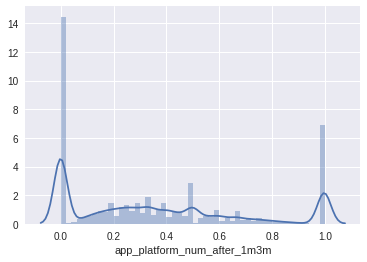

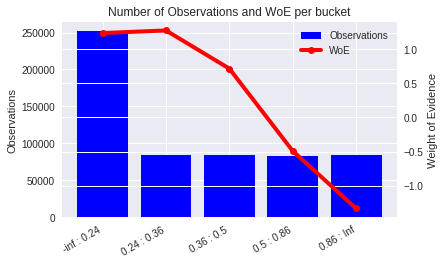

自动分箱调整...
[-inf, 0.3598560575769692, 0.4993757802746567, 0.8565310492505354]


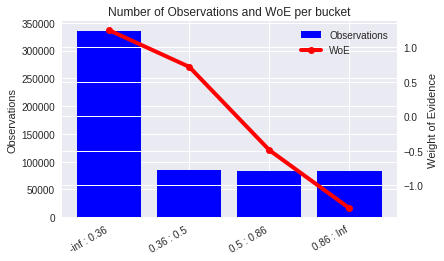

选择最终的woe分箱方法...


In [10]:
continues_cols = ['app_platform_num_after_3m','app_platform_num_after_2m','app_platform_num_after_1m',
                  'app_platform_num_after_25d','app_platform_num_after_21d','app_platform_num_after_15d',
                  'app_platform_num_3m','app_platform_num_1m','app_platform_num_after_21d1m',
                  'app_platform_num_after_25d1m','app_platform_num_after_1m3m']

for Feature in continues_cols:
    print(Feature)
    FeatureWoe = Feature + '_woe'
    def WOE_Transform(Feature, data=raw_data, TargetVar=target_label):
        print('缺失率为: %.4f' % (len(data[data[Feature].isnull() == True]) / len(data)))
        print('输出变量的数据分布...')
        sns.distplot(data[Feature].dropna())

        print('初始化等频分箱...')
        woe1 = pyWoE.WoE(qnt_num=6, min_block_size=10, v_type='c', t_type='b')
        woe1.fit(pd.Series(data[Feature]), pd.Series(data[TargetVar]))
        print(list(woe1.bins['bins'].values))
        fig = woe1.plot()
        plt.show(fig)

        print('自动分箱调整...')
        woe2 = woe1.force_monotonic(hypothesis=1)
        print(list(woe2.bins['bins'].values))
        fig = woe2.plot()
        plt.show(fig)

#     print('手动分箱调整...')
#     woe3 = pyWoE.WoE(bins=[2000.0, 12000.0], v_type='c', t_type='b')
#     woe3.fit(pd.Series(data[Feature]), pd.Series(data[TargetVar]))
#     print(list(woe3.bins['bins'].values))
#     fig = woe3.plot()
#     plt.show(fig)
    
        print('选择最终的woe分箱方法...')
        woe_monotonic = woe1
    
        return woe_monotonic
    woe_monotonic = WOE_Transform(Feature, data=raw_data, TargetVar=target_label)
    raw_data.loc[:, FeatureWoe] = woe_monotonic.transform(pd.Series(raw_data[Feature]))['woe']

    bins_map = woe_monotonic.bins.copy()
    bins_map.loc[:, 'feature'] = FeatureWoe
    woe_monotonic.bins

    tmp = woe_monotonic.bins.copy()
    tmp.loc[:, 'feature'] = FeatureWoe
    if FeatureWoe in set(bins_map['feature']):
        remain_feature = list(set(bins_map['feature']) - set([FeatureWoe]))
        bins_map = bins_map.loc[bins_map['feature'].isin(remain_feature), :]
    bins_map = pd.concat([bins_map, tmp])
    woe_monotonic.bins

**样本分析发现贷后2个月，3个月对风险识别的IV值急剧下降，分析背后原因**

① 猜想：欺诈用户一般在贷后1个月内击中次数过多，从第2个月进入表现期，被多平台拉黑+无还款意愿，造成击中次数极速下降；正常用户每个月要进行还款，击中次数较平滑

② 验证：贷后1个月，2个月，3个月内查询次数，好坏样本的分布差异是否显著

In [7]:
app_train = raw_data[(raw_data['apply_month']>='2018-02') & (raw_data['apply_month']<='2018-07')]

#df[df['first_name'].notnull() & (df['nationality'] == "USA")]

In [12]:
app_train.columns

Index(['order_original_id', 'user_id', 'overdue_1', 'overdue_2', 'overdue_3',
       'overdue_max', 'is_loaned', 'apply_time', 's1d30', 's1d4_30', 's3d15',
       'app_platform_num_after_3m', 'app_platform_num_after_2m',
       'app_platform_num_after_1m', 'app_platform_num_after_25d',
       'app_platform_num_after_21d', 'app_platform_num_after_15d',
       'app_platform_num_after_7d', 'app_platform_num_after_3d',
       'app_platform_num_after_3d7d', 'app_platform_num_after_3d15d',
       'app_platform_num_after_3d21d', 'app_platform_num_after_3d25d',
       'app_platform_num_after_3d1m', 'app_platform_num_after_3d2m',
       'app_platform_num_after_3d3m', 'app_platform_num_after_7d15d',
       'app_platform_num_after_7d21d', 'app_platform_num_after_7d25d',
       'app_platform_num_after_7d1m', 'app_platform_num_after_7d2m',
       'app_platform_num_after_7d3m', 'app_platform_num_after_15d21d',
       'app_platform_num_after_15d25d', 'app_platform_num_after_15d1m',
       'app_platfo

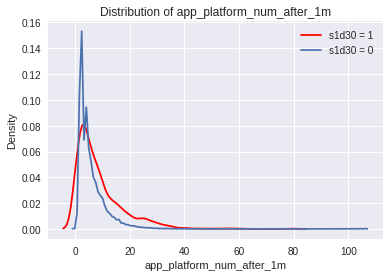

In [21]:
#plt.figure(figsize = (10, 8))
# 选取201802-201807的样本
app_train = raw_data.loc[(raw_data['apply_month']>='2018-02') & (raw_data['apply_month']<='2018-07')]

# KDE plot of loans that were repaid on time
sns.kdeplot(app_train.loc[app_train['s1d30'] == 1, 'app_platform_num_after_1m'], label = 's1d30 = 1',color = 'r')

# KDE plot of loans which were not repaid on time
sns.kdeplot(app_train.loc[app_train['s1d30'] == 0, 'app_platform_num_after_1m'], label = 's1d30 = 0')

# Labeling of plot
plt.xlabel('app_platform_num_after_1m'); plt.ylabel('Density'); plt.title('Distribution of app_platform_num_after_1m');

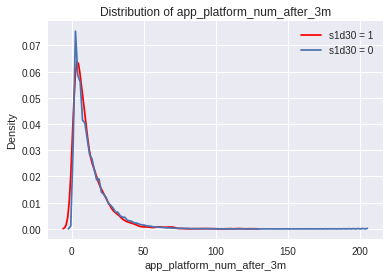

In [20]:
# KDE plot of loans that were repaid on time
sns.kdeplot(app_train.loc[app_train['s1d30'] == 1, 'app_platform_num_after_3m'], label = 's1d30 = 1',color = 'r')

# KDE plot of loans which were not repaid on time
sns.kdeplot(app_train.loc[app_train['s1d30'] == 0, 'app_platform_num_after_3m'], label = 's1d30 = 0')

# Labeling of plot
plt.xlabel('app_platform_num_after_3m'); plt.ylabel('Density'); plt.title('Distribution of app_platform_num_after_3m');

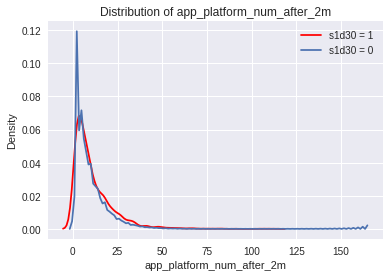

In [19]:
# KDE plot of loans that were repaid on time
sns.kdeplot(app_train.loc[app_train['s1d30'] == 1, 'app_platform_num_after_2m'], label = 's1d30 = 1', color = "r")

# KDE plot of loans which were not repaid on time
sns.kdeplot(app_train.loc[app_train['s1d30'] == 0, 'app_platform_num_after_2m'], label = 's1d30 = 0')

# Labeling of plot
plt.xlabel('app_platform_num_after_2m'); plt.ylabel('Density'); plt.title('Distribution of app_platform_num_after_2m');

双样本的T检验

In [22]:
import numpy as np
import scipy.stats as stats
import scipy.optimize as opt

In [30]:
# 检验好坏样本app_platform_num_after_1m 的分布差异是否显著
data_1 = app_train[app_train['s1d30']==1]['app_platform_num_after_1m'].values
data_0 = app_train[app_train['s1d30']==0]['app_platform_num_after_1m'].values
# 双样本的均值，中位数和标准差
print ("mean of data_1 and data_0 are: " + str(np.mean(data_1))+ "," +str(np.mean(data_0)))
print ("median of data_1 and data_0 are: " + str(np.median(data_1))+ "," +str(np.median(data_0)))
print ("standard deviation of data_1 and data_0 are: " + str(np.std(data_1))+ "," +str(np.std(data_0)))
# T检验是否显著差异
stat_val, p_val = stats.ttest_ind(data_1, data_0, equal_var=False)
#看看两个分布在均值上有没有显著差异
#注意，这里我们生成的第二组数据样本大小、方差和第一组均不相等，在运用t检验时需要使用Welch's t-test
#即指定ttest_ind中的equal_var=False。
print ('Two-sample t-statistic D = %6.3f, p-value = %6.4f' % (stat_val, p_val))


In [33]:
stat_val, p_val = stats.ttest_ind(data_1, data_0, equal_var=False)
#看看两个分布在均值上有没有显著差异
#注意，这里我们生成的第二组数据样本大小、方差和第一组均不相等，在运用t检验时需要使用Welch's t-test
#即指定ttest_ind中的equal_var=False。
print ('Two-sample t-statistic D = %6.3f, p-value = %6.4f' % (stat_val, p_val))

Two-sample t-statistic D = 26.016, p-value = 0.0000


In [38]:
dd = app_train[app_train['apply_month']=='2018-02']

In [39]:
# 检验好坏样本app_platform_num_after_1m 的分布差异是否显著
data_1 = dd[dd['s1d30']==1]['app_platform_num_after_2m'].values
data_0 = dd[dd['s1d30']==0]['app_platform_num_after_2m'].values
# 双样本的均值，中位数和标准差
print ("mean of data_1 and data_0 are: " + str(np.mean(data_1))+ "," +str(np.mean(data_0)))
print ("median of data_1 and data_0 are: " + str(np.median(data_1))+ "," +str(np.median(data_0)))
print ("standard deviation of data_1 and data_0 are: " + str(np.std(data_1))+ "," +str(np.std(data_0)))
# T检验是否显著差异
stat_val, p_val = stats.ttest_ind(data_1, data_0, equal_var=False)
#看看两个分布在均值上有没有显著差异
#注意，这里我们生成的第二组数据样本大小、方差和第一组均不相等，在运用t检验时需要使用Welch's t-test
#即指定ttest_ind中的equal_var=False。
print ('Two-sample t-statistic D = %6.3f, p-value = %6.4f' % (stat_val, p_val))

mean of data_1 and data_0 are: 8.013698630136986,6.887785399815706
median of data_1 and data_0 are: 5.0,4.0
standard deviation of data_1 and data_0 are: 8.627491078052197,7.9837576113993265
Two-sample t-statistic D =  1.924, p-value = 0.0557


In [54]:
def T_Stastic(Data,Target,Group,Val):
    t_list=[]
    p_list=[]
    group_list=[]
    group_df = pd.DataFrame()
    for i in sorted(list(set(Data[Group]))):
        Temp = Data[Data[Group]== i]
        data_1 = Temp[Temp[Target]==1][Val].values
        data_0 = Temp[Temp[Target]==0][Val].values
        t_val, p_val = stats.ttest_ind(data_1, data_0, equal_var=False)
        t_list.append(t_val)
        p_list.append(p_val)
        group_list.append(i)
    t_df = pd.DataFrame(t_list,columns=['t_statistic'],index=group_list)
    p_df = pd.DataFrame(p_list,columns=['p_value'],index=group_list)
    group_df = pd.concat([group_df,t_df,],axis=1)
    group_df = pd.concat([group_df,p_df,],axis=1)
        
    return group_df    
    

In [55]:
T_Stastic(app_train,'s1d30','apply_month','app_platform_num_after_1m')

,t_statistic,p_value
2018-02,6.532284,4.478077e-10
2018-03,11.656283,2.724834e-27
2018-04,12.191369,8.958927e-30
2018-05,13.539015,2.502577e-36
2018-06,12.049595,3.057510e-30
2018-07,4.181299,4.985834e-05


In [56]:
T_Stastic(app_train,'s1d30','apply_month','app_platform_num_after_2m')

,t_statistic,p_value
2018-02,1.923791,5.567476e-02
2018-03,5.780383,1.481997e-08
2018-04,5.139109,4.103575e-07
2018-05,6.541990,1.368647e-10
2018-06,2.638720,8.526011e-03
2018-07,0.386897,6.993965e-01


In [57]:
T_Stastic(app_train,'s1d30','apply_month','app_platform_num_after_3m')

,t_statistic,p_value
2018-02,-2.721560,0.007017
2018-03,0.243493,0.807745
2018-04,-1.112862,0.266352
2018-05,-0.304685,0.760718
2018-06,-2.795523,0.005337
2018-07,0.318160,0.750819
